This notebook is looking at the HAMAD dataset, extracting the data, convert avi to png frames and retrieving the masks from the mat file into png

In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

In [2]:
from pathlib import Path 
import os
import scipy.io as sio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import monai
import torch
import shutil
import tempfile
import pandas as pd
import re

/home/jyoti/Projects/Python/topeka-chapter-ejection-fraction/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from monai.config import print_config
print_config()

MONAI version: 1.1.0
Numpy version: 1.24.2
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/jyoti/Projects/Python/topeka-chapter-ejection-fraction/venv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Update this to where the root of the data is. 
%env DATA_DIRECTORY = /opt/Data

env: DATA_DIRECTORY=/opt/Data


In [5]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/opt/Data


In [6]:
DATA_DIR = 'HAMAD'

In [7]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [8]:
path_dir = Path(os.path.join(root_dir, DATA_DIR))
checkPathExists(path_dir)

Path /opt/Data/HAMAD accessible


In [9]:
from monai.utils import set_determinism
set_determinism(seed=0)

In [10]:
import pprint
pp = pprint.PrettyPrinter()

In [11]:
from monai.apps import extractall

In [12]:
#resource = "https://drive.google.com/uc?export=download&id=1-ZxDlqblE3Ugnyg5nwUQtANmDCkouFwX"
#resource = "https://drive.google.com/file/d/1-ZxDlqblE3Ugnyg5nwUQtANmDCkouFwX/view?usp=sharing"

# Update the path to where the data is stored. 
compressed_path = Path("")
compressed_file = os.path.join(compressed_path, "archive.zip")
checkPathExists(compressed_file)
data_dir = path_dir.joinpath("HMC-QU")
if not os.path.exists(data_dir):
    extractall(compressed_file, data_dir)

Cannot access path: ./archive.zip


### Convert the AVI files to frames

In [18]:
def processvideo(video_file, patient_name, output_dir=None, start_frame=1, end_frame=1):
    image_size = 224
    # Open video file
    video = cv2.VideoCapture(video_file)

    output_patient_path = Path(video_file).parent.joinpath(patient_name)

    if output_dir is not None:
        output_patient_path = Path(output_dir).joinpath(patient_name)

    #pp.pprint(output_patient_path)
        
    output_patient_path.mkdir(parents=True, exist_ok=True)

    # number of frames in video
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Convert frame to image and save to file
    for i in range(start_frame, end_frame+1):
        ret, frame = video.read()
        if ret:
            image_path = output_patient_path.joinpath(f"image_{i}.png")
            arr = cv2.resize(frame,(image_size,image_size))
            cv2.imwrite(str(image_path), arr)

    # Close video file
    video.release()

In [19]:
def processMask(mask_file, patient_name, output_dir, start_frame=1, end_frame=1):
    mat=sio.loadmat(mask_file)# load mat-file
    mdata = mat['predicted']  # variable in mat file 

    output_patient_path = Path(mask_file).parent.joinpath(patient_name)

    if output_dir is not None:
        output_patient_path = Path(output_dir).joinpath(patient_name)

    #pp.pprint(output_patient_path)
        
    output_patient_path.mkdir(parents=True, exist_ok=True)
    frame = start_frame
    for i in range(mdata.shape[0]):
        cv2.imwrite(os.path.join(output_patient_path, f'Mask_{frame}.png'), mdata[i])
        frame = frame+1

1. Collect all the AVI files
2. Load the Info file to gather the one-cycle frames
3. Extract the avi frame and convert to PNG.
4. Get the Mask file and convert to PNG.

In [20]:
a4c_info = pd.read_csv(path_dir.joinpath('A4C_Info.csv'))
TWO_CHANNEL = 'A2C'
FOUR_CHANNEL = 'A4C'
MASK_DIR = 'LV_mask'
VIDEO_FILE_PATH_4CH = data_dir.joinpath(FOUR_CHANNEL)
MASK_FILE_PATH_4CH = path_dir.joinpath(MASK_DIR)
VIDEO_FILE_PATH_2CH = data_dir.joinpath(TWO_CHANNEL)
OUTPUT_DIR_PATH = path_dir.joinpath(FOUR_CHANNEL)
OUTPUT_DIR_PATH.mkdir(parents=True, exist_ok=True)

for i, file in enumerate(a4c_info.echo):
    VIDEO_PATH = VIDEO_FILE_PATH_4CH.joinpath(f"{file}.avi")
    patient_name = re.sub('[\s+]', '', file).split('_')[0]
    processvideo(str(VIDEO_PATH), patient_name, OUTPUT_DIR_PATH, a4c_info.Start[i], a4c_info.End[i])
    MASK_PATH = MASK_FILE_PATH_4CH.joinpath(f"Mask_{file}.mat")
    #checkPathExists(MASK_PATH)
    processMask(MASK_PATH, patient_name, OUTPUT_DIR_PATH, a4c_info.Start[i], a4c_info.End[i])

2. Visualize the image and mask

In [21]:
def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    z_min, z_max = np.abs(mask).min(), np.abs(mask).max()
    plt.imshow(mask, cmap=cmap, alpha=alpha, vmin = z_min, vmax=z_max)

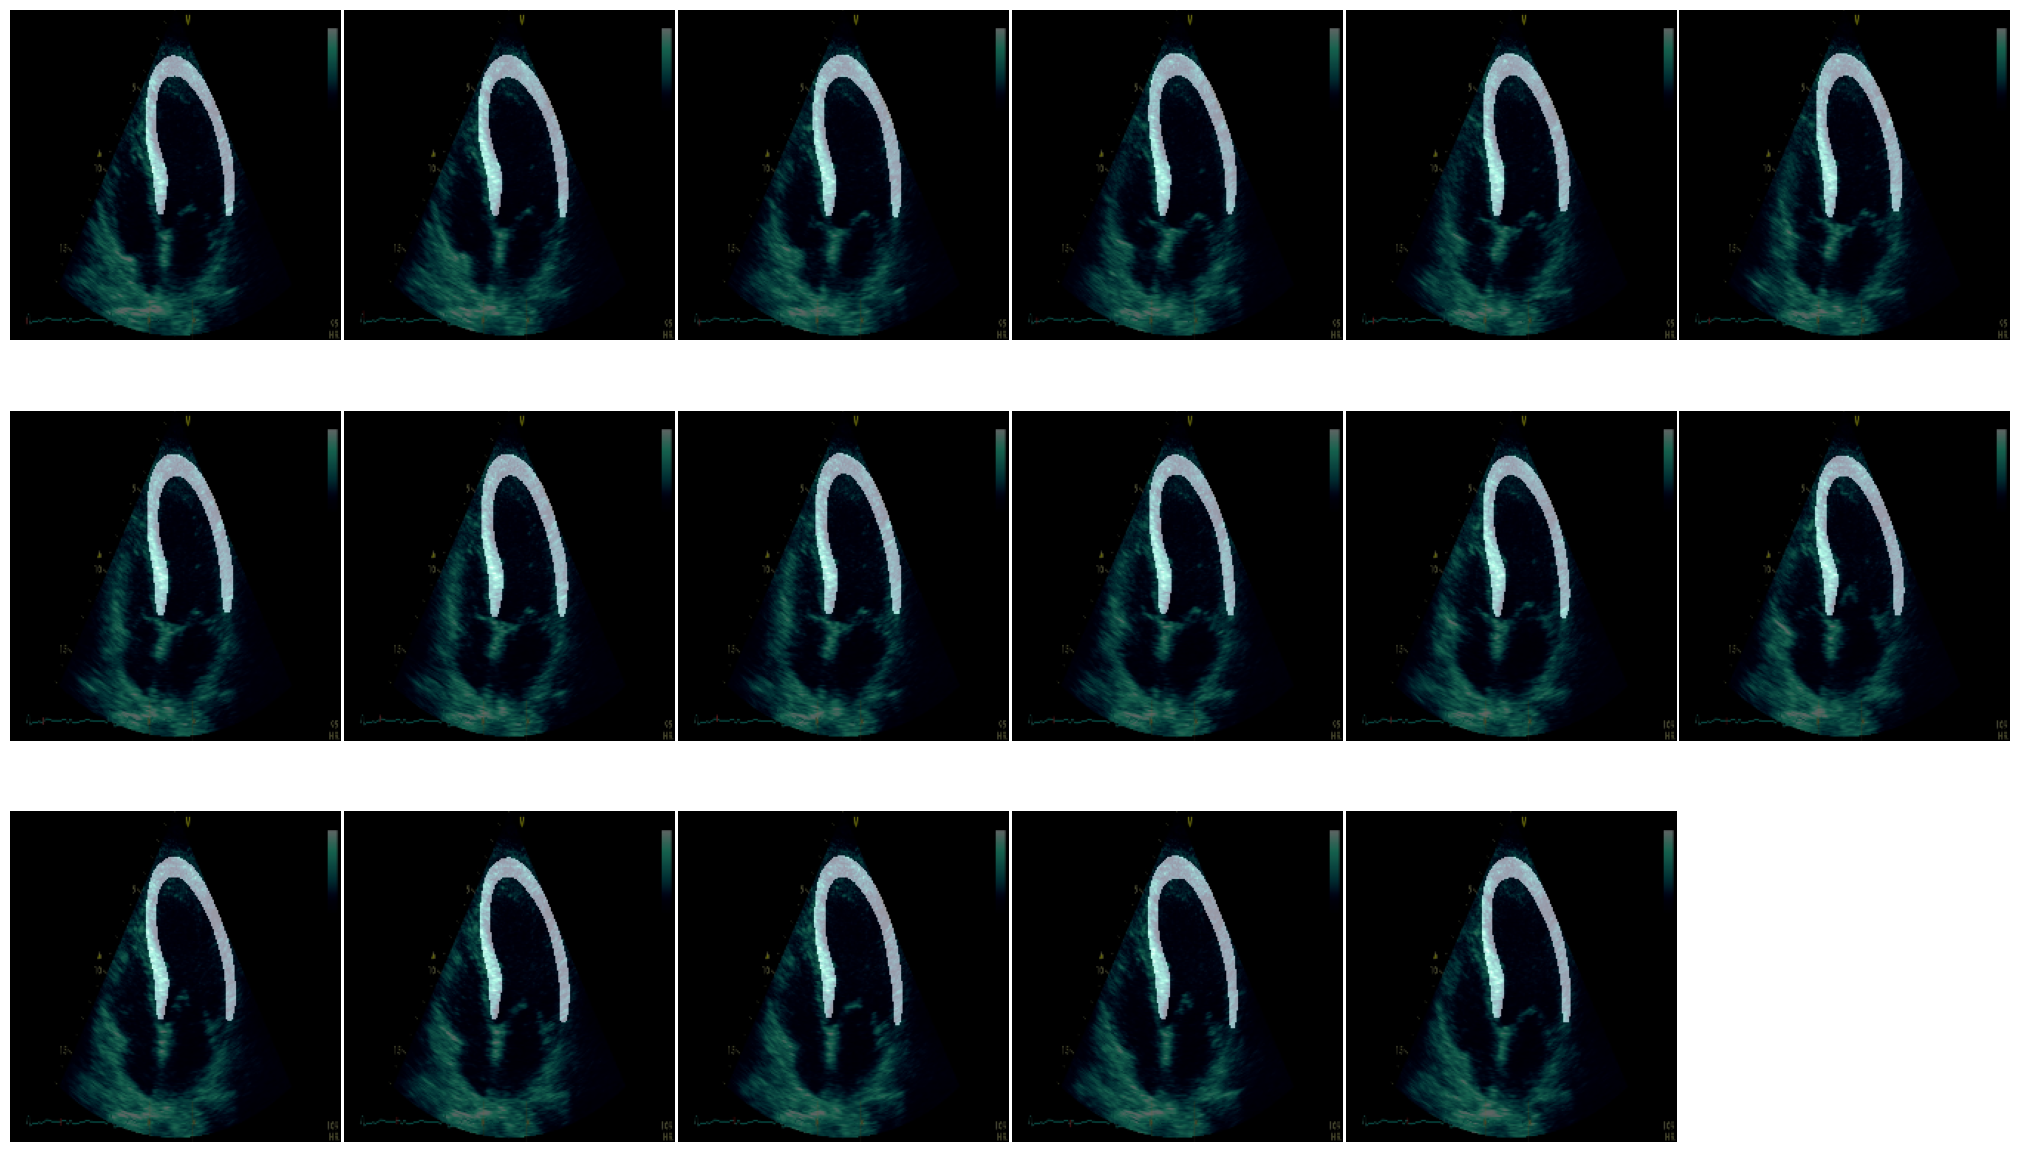

In [24]:
plt.figure(figsize=(20,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
frame = 1
for i in range(a4c_info.Start[6], a4c_info.End[6]+1):
    im = PIL.Image.open(f"/opt/Data/HAMAD/A4C/ES000107/image_{i}.png")
    mask = PIL.Image.open(f"/opt/Data/HAMAD/A4C/ES000107/Mask_{i}.png")
    arr = np.array(im)
    #arr = cv2.resize(arr,(image_size,image_size))
    arr1 = np.array(mask)
    plt.subplot(5, 6, frame)
    show_mask(arr1, arr, cmap='copper'), plt.axis("off")
    frame = frame + 1
plt.show()